### Hypothesis ###
_Daily fruit and veggie intake are good predictors of Heart Disease in Seniors (>65 years)._

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn import metrics
%matplotlib inline

### Import subset of data that has only the columns of interest
_The source data set have over 330 columns and 441000 records. I created a web of causation to determine what columns were important to my analysis_

In [21]:
df = pd.read_csv("../data/extracted_subset.csv")
print df.shape
print df.head()

(441456, 10)
   _MICHD  SEX  MARITAL  _RFBMI5  DIABETE3  _RFCHOL  EXERANY2  FRUIT1  \
0     2.0  2.0      1.0      2.0       3.0      2.0       2.0   310.0   
1     2.0  2.0      2.0      2.0       3.0      1.0       1.0   305.0   
2     NaN  2.0      2.0      1.0       3.0      2.0       NaN     NaN   
3     2.0  2.0      1.0      2.0       3.0      2.0       2.0   101.0   
4     2.0  2.0      1.0      1.0       3.0      1.0       2.0   102.0   

   _AGEG5YR  FVGREEN  
0       9.0    310.0  
1       7.0    202.0  
2      11.0      NaN  
3       9.0    301.0  
4       9.0    204.0  


### Data Preparation

_Exclude nulls and apply age limit_
* No response or NaN for response variable (_MICHD)
* No response to age (_AGEG5YR >= 14)
* Less than 65 years of age (AGEG5YR)
* Null values for cholesterol question (_RFCHOL)
* Null values for exercise (EXERANY2)
* Null values for dailyFruit (FRUIT1)Null value for dailyVeggie (FVGREEN)

In [22]:
df = df[df._MICHD >= 1]
df = df[df._AGEG5YR < 14]
df = df[df._AGEG5YR >= 10]
df = df[df._RFCHOL > 0]
df = df[df.EXERANY2 > 0]
df = df[df.FRUIT1 >= 0]
df = df[df.FVGREEN >= 0]
print df.shape

(133690, 10)


### Data Preparation: Create Dummy Variables

* **HD** (0 = doesnt have heart disease, 1 = has heart disease)
* **single** (0 = not single, 1 = single)
* **diabetic** (0 = does not have diabetes, 1 = has diabetes)
* **male** (0 = female, 1 = male)
* **hicholesterol** (0 = does not have high cholesterol, 1 = has high cholesterol)
* **ow_obese** (0 = not overweight or obese, 1 = is overweight or obese)
* **exercise** (0 = does not exercise regularly, 1 = exercises regularly)

In [23]:
df['single'] = np.where(df.MARITAL==1,0,np.where(df.MARITAL==6,0,1))
df['diabetic'] = np.where(df.DIABETE3==1,1,np.where(df.DIABETE3==2,1,0))
df['male'] = np.where(df.SEX == 1,1,0)
df['hicholesterol'] = np.where(df._RFCHOL == 2, 1, 0)
df['ow_obese'] = np.where(df._RFBMI5 == 2, 1, 0)
df['exercise'] = np.where(df.EXERANY2 == 1, 1, 0)
df['HD'] = np.where(df['_MICHD']==1, 1, 0)

### Data Preparation: Create dailyFruit and dailyVeggie features

_Below I have written functions to decode the values for FRUIT1 and FVGREEN columns from original data source_

In [24]:
def fruit2daily_fruit(row):
    if row['FRUIT1'] >= 100 and row['FRUIT1'] < 200:
        val = row['FRUIT1']-100
    elif row['FRUIT1'] >= 200 and row['FRUIT1'] < 300:
        val = (row['FRUIT1']-200)/7
    elif row['FRUIT1'] == 300:
        val = 0.02
    elif row['FRUIT1'] > 300 and row['FRUIT1']<400:
        val = (row['FRUIT1'] - 300)/30
    elif row['FRUIT1'] == 555:
        val = 0
    else: 
        val = float('NaN')
    return val

def fvgreen2daily_veggie(row):
    if row['FVGREEN'] >= 100 and row['FVGREEN'] < 200:
        val = row['FVGREEN']-100
    elif row['FVGREEN'] >= 200 and row['FVGREEN'] < 300:
        val = (row['FVGREEN']-200)/7
    elif row['FVGREEN'] == 300:
        val = 0.02
    elif row['FVGREEN'] > 300 and row['FVGREEN']<400:
        val = (row['FVGREEN'] - 300)/30
    elif row['FVGREEN'] == 555:
        val = 0
    else: 
        val = float('NaN')
    return val

### The following section creates dailyFruit and dailyVeggie features. It takes a couple of minutes to run. So please be patient!!

In [25]:
df['dailyFruit'] = df.apply(fruit2daily_fruit,axis = 1) 
df['dailyVeggie'] = df.apply(fvgreen2daily_veggie,axis = 1)

In [26]:
df.dailyFruit.describe()

count    130982.000000
mean          1.013789
std           1.097936
min           0.000000
25%           0.428571
50%           1.000000
75%           1.000000
max          99.000000
Name: dailyFruit, dtype: float64

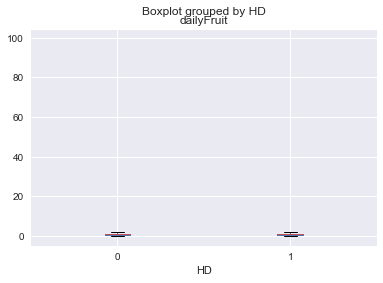

In [27]:
df.boxplot(column="dailyFruit", by="HD")

### Data Preparation: Exclude no responses / nulls for dailyFruit and dailyVeggie columns. Also exclude outliers!!

_I have excluded any response that is greater than 3 for dailyFruit and dailyVeggie variables_

In [28]:
df = df[df.dailyFruit >= 0]
df = df[df.dailyVeggie >= 0]
df = df[df.dailyFruit <= 3]
df = df[df.dailyVeggie <= 3]
df.shape

(127038, 19)

### Create a new dataframe with final list of columns

In [29]:
final_cols = ["HD","dailyFruit","dailyVeggie","exercise","single","ow_obese","hicholesterol","male","diabetic"]
df = df[final_cols]
df.shape

(127038, 9)

### Data Exploration

* Box plots for dailyFruit and dailyVeggie features by HD (0, 1)
* Correlation heatmap for all variables

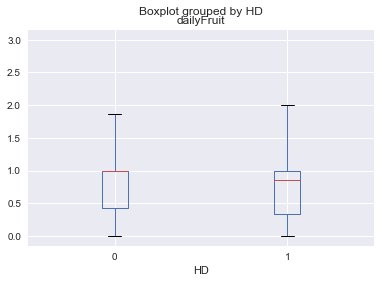

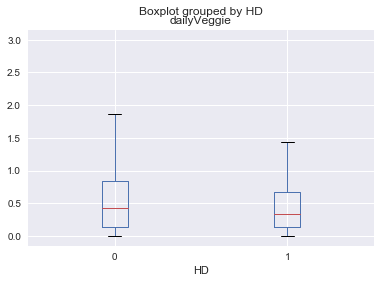

In [30]:
df.boxplot(column="dailyFruit", by="HD")
df.boxplot(column="dailyVeggie", by="HD")

### Correlation Heatmap

* Columns dailyFruit and dailyVeggie are correlated with each other. 
* Columns diabetic, male and hicholesterol are **slightly** correlated with response variable HD
* Almost all correlations are insignificant!! <0.5

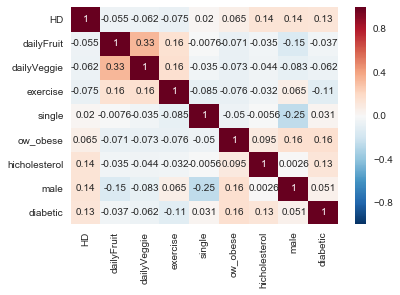

In [31]:
sns.heatmap(df.corr(), annot=True)

### Save subset of clean data to CSV

_I am doing this so that anytime I want to try new models, I can simply load the final CSV and avoid all the above preprocessing steps_

In [32]:
df.to_csv("../data/final_data_set.csv",index=False)

### Read final dataset from CSV into dataframe

In [69]:
df = pd.read_csv("../data/final_data_set.csv")
print df.shape

(127038, 9)


### Preliminary analysis with Logistic Regression

#### Conclusions
* Accuracy as good as null accuracy
* Recall is zero ie this model is always predicting 0s over 1s

In [50]:
feature_cols = ["dailyFruit","dailyVeggie"]
X = df[feature_cols]
y = df.HD
logReg = LogisticRegression()
print X.shape, y.shape
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)
logReg.fit(X_train,y_train)    
y_pred_class = logReg.predict(X_test)
print "Null Accuracy: ", float(y.value_counts()[0])/len(y)
print "Accuracy: ", metrics.accuracy_score(y_test, y_pred_class)
print "Recall: ", metrics.recall_score(y_test, y_pred_class)
print metrics.confusion_matrix(y_test, y_pred_class)

(127038, 2) (127038L,)
Null Accuracy:  0.828681182009
Accuracy:  0.829722921914
Recall:  0.0
[[26352     0]
 [ 5408     0]]


### Preliminary analysis with KNN

#### Conclusions
* Accuracy is worse compared to null accuracy
* Recall is 13% ie this model correctly identifies people with heart disease 13% of times

In [35]:
# Initial analysis with KNN
feature_cols = ["dailyFruit","dailyVeggie"]
X = df[feature_cols]
y = df.HD
print X.shape, y.shape
knn = KNeighborsClassifier(n_neighbors= 1)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)
knn.fit(X_train,y_train)    
y_pred_class = knn.predict(X_test)
print "Accuracy: ", metrics.accuracy_score(y_test, y_pred_class)
print "Recall: ", metrics.recall_score(y_test, y_pred_class)
print metrics.confusion_matrix(y_test, y_pred_class)

(127038, 2) (127038L,)
Accuracy:  0.750409319899
Recall:  0.133136094675
[[23113  3239]
 [ 4688   720]]


### Tricks to handle Imbalanced Data

* **Undersampling**: I decided to balance my data so that number of records with HD = 0 is the same as the number of records with HD = 1. This means that null accuracy of this subset would be 50%.


* **Use of Cost Sensitive Measure for Validation**: I also decided to use f1 score as it is important to know what percentage of actual positives is the model able to predict correctly. F1 score is combination of precision and recall. The greater the value the better the model prediction

In [70]:
df_original = df
print "# records before under sampling: ", df.shape
sample_size = sum(df_original.HD == 1)
HD_indices = df_original[df_original.HD == 1].index
nonHD_indices = df_original[df_original.HD == 0].index
random_indices = np.random.choice(nonHD_indices, sample_size, replace=False)
df = df_original.loc[random_indices]
df = df.append(df_original.loc[HD_indices])
print "# records after under sampling: ", df.shape

# records before under sampling:  (127038, 9)
# records after under sampling:  (43528, 9)


### Using KNN on undersampled data and using f1 score as metric for validation

In [53]:
# Analysis with KNN on Under sampled data
feature_cols = ["dailyFruit","dailyVeggie"]
X = df[feature_cols]
y = df.HD
print "Null accuracy of undersampled data: ",float(y.value_counts()[0])/len(y) 
print X.shape, y.shape
scores_df = pd.DataFrame(columns = ("neighbors","metric"))

for i in range(1,10):
    knn = KNeighborsClassifier(n_neighbors= i)
    scores = cross_val_score(knn, X, y, cv=10, scoring='f1')
    scores_df.loc[i] = [i,scores.mean()]
#print scores_df
print scores_df.loc[scores_df['metric'].idxmax()]

Null accuracy of undersampled data:  0.5
(43528, 2) (43528L,)
neighbors    1.00000
metric       0.45872
Name: 1, dtype: float64


### Use train test split with KNN, undersampled data and f1 score

In [57]:
# Try predicting using train test split
knn = KNeighborsClassifier(n_neighbors= 1)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=2)
knn.fit(X_train,y_train)    
y_pred_class = knn.predict(X_test)
#print metrics.accuracy_score(y_test, y_pred_class)

print "f1 score: ", metrics.f1_score(y_test, y_pred_class)
print "accuracy: ", metrics.accuracy_score(y_test, y_pred_class)

print metrics.confusion_matrix(y_test, y_pred_class)

f1 score:  0.523767293366
accuracy:  0.506524535931
[[2559 2795]
 [2575 2953]]


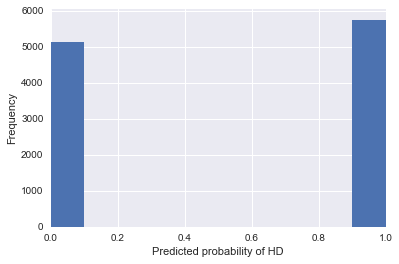

In [56]:
y_pred_prob = knn.predict_proba(X_test)[:, 1]
plt.hist(y_pred_prob)
plt.xlim(0, 1)
plt.xlabel('Predicted probability of HD')
plt.ylabel('Frequency')

### Problem with analysis so far

_The model has a high bias as it achieves best f1 score at K = 1_

### Running this model using only one feature : dailyFruit

_I faced the same problem using dailyFruit as the only feature, the model had a high bias as it yielded the best f1 score for k = 1_

In [58]:
# Analysis with KNN on Under sampled data with dailyFruit only
feature_cols = ["dailyFruit"]
X = df[feature_cols]
y = df.HD
#print X.shape, y.shape
scores_df = pd.DataFrame(columns = ("neighbors","metric"))

for i in range(1,10):
    knn = KNeighborsClassifier(n_neighbors= i)
    scores = cross_val_score(knn, X, y, cv=10, scoring='f1')
    scores_df.loc[i] = [i,scores.mean()]
#print scores_df
print scores_df.loc[scores_df['metric'].idxmax()]

neighbors    1.000000
metric       0.425504
Name: 1, dtype: float64


### Use additional features such as exercise, diabetic and hicholesterol along with dailyFruit and dailyVeggie

_I observed best value of f1 score at 0.60 as well as accuracy = 0.60 at k = 50; after which I observed diminishing returns for both f1 score and accuracy._

In [59]:
# Analysis with KNN on under sampled data
feature_cols = ["dailyFruit","dailyVeggie","exercise","diabetic","hicholesterol"]
X = df[feature_cols]
y = df.HD
#print X.shape, y.shape
scores_df = pd.DataFrame(columns = ("neighbors","metric"))

for i in range(1,50):
    knn = KNeighborsClassifier(n_neighbors= i)
    scores = cross_val_score(knn, X, y, cv=10, scoring='f1')
    scores_df.loc[i] = [i,scores.mean()]
#print scores_df
print scores_df.loc[scores_df['metric'].idxmax()]

neighbors    49.000000
metric        0.589298
Name: 49, dtype: float64


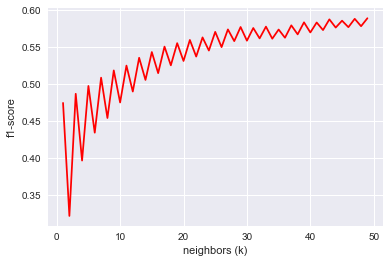

In [60]:
plt.plot(scores_df.neighbors, scores_df.metric, color='red')
plt.xlabel('neighbors (k)')
plt.ylabel('f1-score')

### Use accuracy for model validation

_I observed best value of f1 score at 0.60 as well as accuracy = 0.60 at k = 50; after which I observed diminishing returns for both f1 score and accuracy._

In [63]:
# Analysis with KNN on under sampled data with accuracy
feature_cols = ["dailyFruit","dailyVeggie","exercise","diabetic","hicholesterol"]
X = df[feature_cols]
y = df.HD
#print X.shape, y.shape
scores_df = pd.DataFrame(columns = ("neighbors","metric"))

for i in range(1,50):
    knn = KNeighborsClassifier(n_neighbors= i)
    scores = cross_val_score(knn, X, y, cv=10, scoring='accuracy')
    scores_df.loc[i] = [i,scores.mean()]
#print scores_df
print scores_df.loc[scores_df['metric'].idxmax()]

neighbors    49.000000
metric        0.598374
Name: 49, dtype: float64


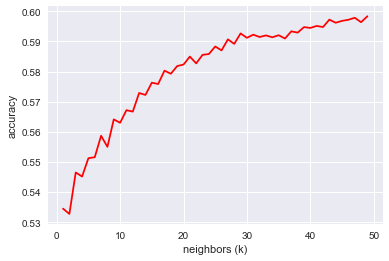

In [64]:
plt.plot(scores_df.neighbors, scores_df.metric, color='red')
plt.xlabel('neighbors (k)')
plt.ylabel('accuracy')

In [72]:
# Try predicting using train test split
feature_cols = ["dailyFruit","dailyVeggie","exercise","diabetic","hicholesterol"]
X = df[feature_cols]
y = df.HD
knn = KNeighborsClassifier(n_neighbors= 50)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=300)
knn.fit(X_train,y_train)    
y_pred_class = knn.predict(X_test)
#print metrics.accuracy_score(y_test, y_pred_class)
print "f1-score: ", metrics.f1_score(y_test, y_pred_class)
print "accuracy: ", metrics.accuracy_score(y_test, y_pred_class)
print metrics.confusion_matrix(y_test, y_pred_class)

f1-score:  0.596096096096
accuracy:  0.604484469767
[[3402 1998]
 [2306 3176]]


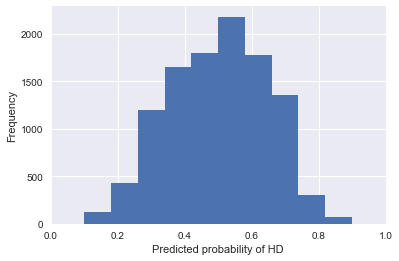

In [73]:
y_pred_prob = knn.predict_proba(X_test)[:, 1]
plt.hist(y_pred_prob)
plt.xlim(0, 1)
plt.xlabel('Predicted probability of HD')
plt.ylabel('Frequency')

### Conclusion

**I conclude that dailyFruit and dailyVeggie intake are good predictors of heart disease as compared to features such as diabetes, hi cholesterol or exercise. Yet best results are achieved only when all these 5 features are used together for predicting heart disease in seniors.**

### Next Steps

* Include other variables
* Apply other models
* Apply Oversampling
* Apply Undersampling with a different ratio
* Impute values instead of excluding nulls